# Rock, Paper, Scissors

#### Import modules

In [15]:
import tensorflow as tf
from tensorflow import keras
import numpy
import matplotlib.pyplot as plt
import os
import random
import sklearn
from sklearn.model_selection import StratifiedKFold
import pandas
from seaborn import boxplot
from matplotlib import pyplot



#### Default values

In [16]:
# IMPORT IMAGES
dir_images_train = "C:\\zImagens\\train"
image_size = (32,32)
batch_size = 1

# TRAINING
the_seed = 32
input_shape = image_size + (1,)
convnn_acivation = 'relu'
fully_connected_acivation = 'tanh'
hyperparameter_max = 16
learning_rate = 0.001
max_epochs = 5
score_metric = 'accuracy'
verbose = 1
phi = 360
n_folds = 10

# SET RANDOM
random.seed(the_seed)
numpy.random.seed(the_seed)
tf.random.set_seed(the_seed)

#### Import images to training dataset

In [17]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=dir_images_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

train_images = []
train_labels = []

for image, label in train_ds:
    train_images.append(image.numpy())
    train_labels.append(label.numpy())

train_images = numpy.concatenate(train_images, axis = 0)
train_labels = numpy.concatenate(train_labels, axis = 0)

Found 4741 files belonging to 3 classes.


#### Training

In [18]:
def create_rps(input_size : tuple[int, int, int] = (32, 32, 1),
                      convnn_acivation : str = 'relu',
                      fully_connected_acivation : str = 'tanh',
                      net_name : str = 'RPS',
                      hyperparameter : int = 1,
                      phi = 360):
    
    filter_size = (3,3)
    pooling_size = (2,2)
    
    # CAMADA OCULTA
    inputs = tf.keras.Input(shape=input_size)
    
    # RESCALING
    scale_layer = tf.keras.layers.Rescaling(scale= 1/127.5, offset= -1)
    x = scale_layer(inputs)
    
    # CAMADA DE AUMENTO DE DADOS
    rotator = tf.keras.layers.RandomRotation(phi)
    x = rotator(x)

    # PRIMEIRA CAMADA CONVOLUCIONAL + POOL
    conv_2d_layer_1 = tf.keras.layers.Conv2D(1 * hyperparameter, filter_size, activation = convnn_acivation)
    x = conv_2d_layer_1(x)
    maxpool_1 = tf.keras.layers.MaxPooling2D(pooling_size)
    x = maxpool_1(x)

    # SEGUNDA CAMADA CONVOLUCIONAL + POOL
    conv_2d_layer_2 = tf.keras.layers.Conv2D(2 * hyperparameter, filter_size, activation = convnn_acivation)
    x = conv_2d_layer_2(x)
    maxpool_2 = tf.keras.layers.MaxPooling2D(pooling_size)
    x = maxpool_2(x)

    # TERCEIRA CAMADA CONVOLUCIONAL + POOL
    conv_2d_layer_3 = tf.keras.layers.Conv2D(4 * hyperparameter, filter_size, activation = convnn_acivation)
    x = conv_2d_layer_3(x)
    maxpool_3 = tf.keras.layers.MaxPooling2D(pooling_size)
    x = maxpool_3(x)

    # FLATTEN
    flatten_layer = tf.keras.layers.Flatten()
    x = flatten_layer(x)

    # FULLY CONNECTED HIDDEN LAYER
    hidden_layer = tf.keras.layers.Dense(64 * hyperparameter, activation = convnn_acivation)
    x = hidden_layer(x)

    # OUTPUT LAYER
    output_layer = tf.keras.layers.Dense(3, activation = fully_connected_acivation)
    outputs = output_layer(x)

    return tf.keras.Model(inputs = inputs, outputs = outputs, name = net_name)

In [19]:
result_list = []
kfolder = StratifiedKFold(n_splits = n_folds, random_state = the_seed, shuffle = True)

for hyperparameter in numpy.arange(1, hyperparameter_max + 1):
    for i, (train_index, validation_index) in enumerate(kfolder.split(train_images, train_labels)):
        print(f"Starting h: {hyperparameter} f: {i}")
        X_train, Y_train = train_images[train_index], train_labels[train_index]
        X_val, Y_val = train_images[validation_index], train_labels[validation_index]
        
        # NET NAME > Hyperparameter + Fold Number
        net_name = f"RPS_H{hyperparameter}_F{i}"
        print(f"{net_name} training started...")
        
        rps_net = create_rps(net_name = net_name, 
                                        hyperparameter = hyperparameter)
        
        opt = keras.optimizers.Adam(learning_rate = learning_rate)
        
        rps_net.compile(optimizer=opt ,
                    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[score_metric])

        history = rps_net.fit(X_train, Y_train, epochs = max_epochs, 
                            validation_data=(X_val, Y_val), 
                            verbose = verbose)
        
        training_score = history.history[score_metric][-1]
        validation_score = history.history[f"val_{score_metric}"][-1]
        
        result_list.append((net_name, hyperparameter, i, training_score, validation_score, rps_net))
        print(f"{net_name.upper()}: {100 * training_score:.0f}% TRAINING {score_metric.upper()} / {100 * validation_score:.0f}% VALIDATION {score_metric.upper()}")

Starting h: 1 f: 0
RPS_H1_F0 training started...
Epoch 1/5
134/134 [==============================] - 2s 7ms/step - loss: 1.0735 - accuracy: 0.4299 - val_loss: 1.0753 - val_accuracy: 0.4337
Epoch 2/5
134/134 [==============================] - 1s 6ms/step - loss: 1.0053 - accuracy: 0.5080 - val_loss: 1.0706 - val_accuracy: 0.4653
Epoch 3/5
134/134 [==============================] - 1s 6ms/step - loss: 0.9717 - accuracy: 0.5263 - val_loss: 1.0042 - val_accuracy: 0.4611
Epoch 4/5
134/134 [==============================] - 1s 6ms/step - loss: 0.9505 - accuracy: 0.5265 - val_loss: 0.9827 - val_accuracy: 0.5011
Epoch 5/5
134/134 [==============================] - 1s 6ms/step - loss: 0.9298 - accuracy: 0.5431 - val_loss: 0.9401 - val_accuracy: 0.5137
RPS_H1_F0: 54% TRAINING ACCURACY / 51% VALIDATION ACCURACY
Starting h: 1 f: 1
RPS_H1_F1 training started...
Epoch 1/5
134/134 [==============================] - 2s 7ms/step - loss: 1.0850 - accuracy: 0.3937 - val_loss: 1.0545 - val_accuracy: 0.46

In [20]:
results = pandas.DataFrame.from_records(result_list)
results.columns = ["net_name", 'hyperparameter', "kfold", score_metric, f"val_{score_metric}", "rps"]
results.sort_values("val_accuracy", ascending = False)

,net_name,hyperparameter,kfold,accuracy,val_accuracy,rps
155,RPS_H16_F5,16,5,0.943051,0.962025,<keras.engine.functional.Functional object at ...
115,RPS_H12_F5,12,5,0.923834,0.953587,<keras.engine.functional.Functional object at ...
75,RPS_H8_F5,8,5,0.894071,0.953587,<keras.engine.functional.Functional object at ...
135,RPS_H14_F5,14,5,0.934380,0.949367,<keras.engine.functional.Functional object at ...
125,RPS_H13_F5,13,5,0.936021,0.949367,<keras.engine.functional.Functional object at ...
...,...,...,...,...,...,...
1,RPS_H1_F1,1,1,0.531287,0.565401,<keras.engine.functional.Functional object at ...
6,RPS_H1_F6,1,6,0.527303,0.527426,<keras.engine.functional.Functional object at ...
0,RPS_H1_F0,1,0,0.543132,0.513684,<keras.engine.functional.Functional object at ...
18,RPS_H2_F8,2,8,0.649637,0.502110,<keras.engine.functional.Functional object at ...


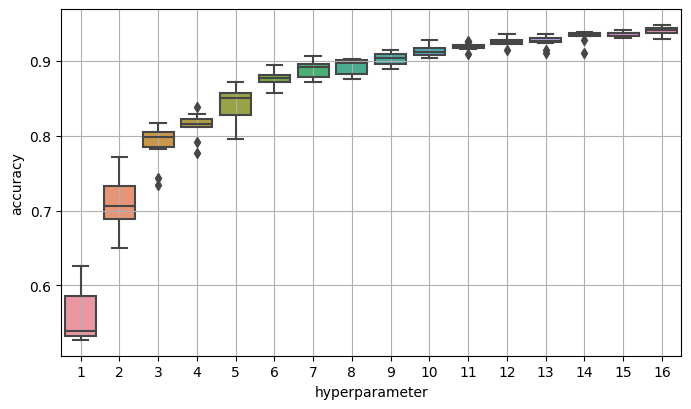

In [21]:
fig = pyplot.figure(figsize = (8, 4.5))
ax = fig.add_subplot(111)
boxplot(results, x = 'hyperparameter', y = 'accuracy', ax = ax)
ax.grid()